In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [3]:
data_dir = "/projects/robustmicrob/jlaw/inputs/species/bacdive"

## Pre-train with OGTmax (organism growth temperature - max)

In [4]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [5]:
out_dir = f"{data_dir}/embeddings"

In [6]:
prefix = "20230614_embeddings"
model = "esm2_t33_650M_UR50D"

In [8]:
all_embeddings = []
all_seqs = []
for i in range(9):
    embed_file = f"{out_dir}/{prefix}_{model}_{i}.npz"
    seq_idx_file = f"{out_dir}/{prefix}_seqs_{i}.csv"
    embeddings, seqs = read_embeddings(embed_file, seq_idx_file)
    all_embeddings.append(embeddings)
    all_seqs.append(seqs)
    
all_embeddings = np.vstack(all_embeddings)
print(all_embeddings.shape)
labels = pd.concat(all_seqs)
print(labels.shape)

len(embeddings) = 38839 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_esm2_t33_650M_UR50D_0.npz
len(sequences) = 38839 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_seqs_0.csv
len(embeddings) = 38839 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_esm2_t33_650M_UR50D_1.npz
len(sequences) = 38839 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_seqs_1.csv
len(embeddings) = 38839 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_esm2_t33_650M_UR50D_2.npz
len(sequences) = 38839 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_seqs_2.csv
len(embeddings) = 38839 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_esm2_t33_650M_UR50D_3.npz
len(sequences) = 38839 read from /projects/robustmicro

In [10]:
embed_file = f"{out_dir}/{prefix}_{model}.npz"
seq_idx_file = f"{out_dir}/{prefix}_seqs.csv"
print(embed_file)
np.savez(embed_file, all_embeddings)
labels.to_csv(seq_idx_file, index=False)

/projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_esm2_t33_650M_UR50D.npz


In [7]:
# combine these most recent embeddings with previous embeddings
embed_file = f"{out_dir}/{prefix}_{model}.npz"
seq_idx_file = f"{out_dir}/{prefix}_seqs.csv"
all_embeddings, labels = read_embeddings(embed_file, seq_idx_file)

len(embeddings) = 349551 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 349551 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_embeddings_seqs.csv


In [8]:
# combine these most recent embeddings with previous embeddings
prefix2 = "20230516_embeddings"
embed_file = f"{out_dir}/{prefix2}_{model}.npz"
seq_idx_file = f"{out_dir}/{prefix2}_seqs.csv"
embeddings2, seqs2 = read_embeddings(embed_file, seq_idx_file)

len(embeddings) = 1089270 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230516_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 1089270 read from /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230516_embeddings_seqs.csv


In [9]:
embeddings = np.vstack([all_embeddings, embeddings2])
print(embeddings.shape)
labels = pd.concat([labels, seqs2])
print(labels.shape)

(1438821, 1280)
(1438821, 3)


In [10]:
labels = labels.drop(columns='sequence')

In [11]:
labels.head(2)

,accession,OGTmax
0,A0A7K3WUA8,10.0
1,H5TB01,10.0


In [12]:
df_clust = pd.read_csv("/projects/robustmicrob/jlaw/inputs/species/bacdive/proteomes/uniref90_50_mapping.csv.gz", index_col=0)
df_clust.head(2)

,accession,uniref90,uniref50
0,Q9V2L2,UniRef90_Q9V2L2,UniRef50_Q9V2L2
1,Q8U4R3,UniRef90_Q8U4R3,UniRef50_Q8U4R3


In [38]:
# change the labels to be a binary classifier
cutoff = 60
cutoff_col = f'gt{cutoff}'
labels[cutoff_col] = (labels['OGTmax'] >= cutoff).astype(int)

In [13]:
# cutoff 70
npos, nneg = len(labels[labels[cutoff_col] > 0]), len(labels[labels[cutoff_col] == 0])
print(npos, nneg, npos / len(labels))

165157 1273664 0.11478634242897483


In [39]:
cutoff 60
npos, nneg = len(labels[labels[cutoff_col] > 0]), len(labels[labels[cutoff_col] == 0])
print(npos, nneg, npos / len(labels))

337804 1101017 0.23477833587360764


In [40]:
# split into train and test sets
# I included only one sequence per cluster per bin for building the dataset, 
# so no need to incorporate clusters here (unless we want to include all sequences in a test cluster)
train, test = train_test_split(labels.accession, train_size=0.95, random_state=1)

seq_idx = {u: i for i, u in enumerate(labels.accession)}
train_idxs = sorted([seq_idx[u] for u in train])
test_idxs = sorted([seq_idx[u] for u in test])

X_train = embeddings[train_idxs]
# y_train = labels.iloc[train_idxs].OGTmax.values
y_train = labels.iloc[train_idxs][cutoff_col].values
X_test = embeddings[test_idxs]
# y_test = labels.iloc[test_idxs].OGTmax.values
y_test = labels.iloc[test_idxs][cutoff_col].values

print(len(train), len(test), f"{len(test) / len(labels):0.2f}")

1366879 71942 0.05


In [15]:
import torch
from torch import nn
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.loggers import TensorBoardLogger

In [16]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, initial_layer_size=1280):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, 512),
            nn.ReLU(),            
            nn.Linear(512, 512),
            nn.ReLU(),            
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.loss = nn.BCELoss()

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        # print(x, y_pred, y)
        loss = self.loss(y_pred, y)
        # loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        loss = self.loss(y_pred, y)
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [17]:
def fit_model(X_train, y_train, X_valid, y_valid, logger=None):
    pl.seed_everything(42)
    model = NeuralNetwork(initial_layer_size=X_train.shape[1])
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        # max_epochs=20,
        max_epochs=10,
        check_val_every_n_epoch=5,
        logger=logger,
    )
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid).to(device), torch.Tensor(y_valid).to(device))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

    trainer.fit(model, train_loader, valid_loader)
    
    return model, trainer

In [18]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [41]:
logger = TensorBoardLogger(f"{out_dir}/tb_logs", name=f"{prefix}_{cutoff_col}_uniref50")
    
head_model_60, trainer = fit_model(X_train, y_train, X_test, y_test, logger=logger)

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/tb_logs/20230614_embeddings_gt60_uniref50
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 951 K 
1 | loss              | BCELoss    | 0     
-------------------------------------------------
951 K     Trainable params
0         Non-t

Sanity Checking: 0it [00:00, ?it/s]

/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=10` reached

In [35]:
y_pred

array([0.03686421, 0.13685271, 0.07786717, ..., 0.14335257, 0.94641244,
       0.61928564], dtype=float32)

fmax: 0.7340609893283877; prec: 0.7431667077074612, rec: 0.7251757073346549, fmax_idx = 54555


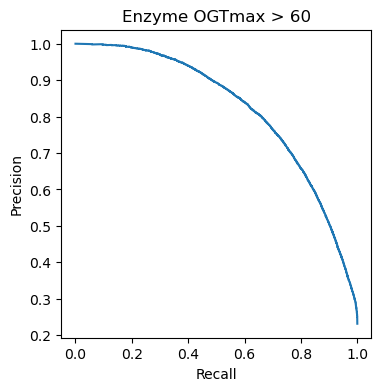

In [43]:
from sklearn.metrics import precision_recall_curve
# now measure the precision and recall as well as accuracy
# y_pred = head_model(torch.Tensor(X_test)).detach().squeeze().cpu().numpy()
y_pred = head_model_60(torch.Tensor(X_test)).detach().squeeze().cpu().numpy()

prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
f1 = [2 * ((p*r) / (p+r)) for p, r in zip(prec, rec)]
fmax_idx = np.argmax(f1)
print(f"fmax: {f1[fmax_idx]}; prec: {prec[fmax_idx]}, rec: {rec[fmax_idx]}, {fmax_idx = }")

df = pd.DataFrame({'prec': prec, 'rec': rec})
f, ax = plt.subplots(figsize=(4,4))
df.plot(x='rec', y='prec', ax=ax)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Enzyme OGTmax > 60")
ax.get_legend().remove()

fmax: 0.7146730563087206; prec: 0.7364522417153996, rec: 0.6941450269475747, fmax_idx = 62183


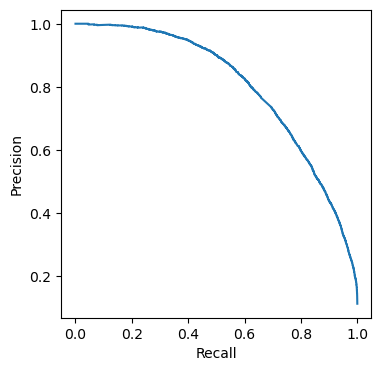

In [25]:
# cutoff 70
from sklearn.metrics import precision_recall_curve
# now measure the precision and recall as well as accuracy
y_pred = head_model(torch.Tensor(X_test)).detach().squeeze().cpu().numpy()

prec, rec, thresholds = precision_recall_curve(y_test, y_pred)
f1 = [2 * ((p*r) / (p+r)) for p, r in zip(prec, rec)]
fmax_idx = np.argmax(f1)
print(f"fmax: {f1[fmax_idx]}; prec: {prec[fmax_idx]}, rec: {rec[fmax_idx]}, {fmax_idx = }")

df = pd.DataFrame({'prec': prec, 'rec': rec})
f, ax = plt.subplots(figsize=(4,4))
df.plot(x='rec', y='prec', ax=ax)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.get_legend().remove()

In [28]:
thresholds[fmax_idx]

0.4032189

(array([55794.,  3370.,  1760.,  1231.,   909.,   775.,   710.,   723.,
          783.,  2967.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

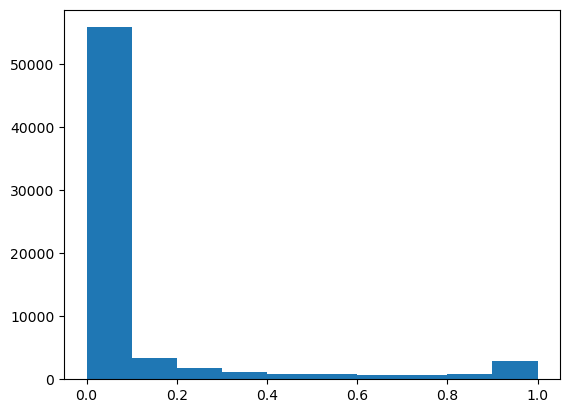

In [33]:
plt.hist(thresholds)

In [37]:
print(thresholds[50000], prec[50000])

0.0380261 0.38210891537185093


In [45]:
out_file = Path(out_dir, f"20230614_bacdive_uniref50_{cutoff_col}.pt")
print(out_file)
# trainer.save_checkpoint(out_file)
torch.save(head_model_60, out_file)

/projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_bacdive_uniref50_gt60.pt


In [19]:
# y_pred = fit_predict(X_train, y_train, X_test).flatten()
# y_pred = model(torch.Tensor(X_test).to('cuda')[2].unsqueeze(1).detach().cpu()
y_pred = head_model(torch.Tensor(X_test)).detach().squeeze().cpu().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = np.abs(y_pred - y_test).mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 10.1, mse = 164.4, rho = 0.67


In [109]:
# y_pred = fit_predict(X_train, y_train, X_test).flatten()
# y_pred = model(torch.Tensor(X_test).to('cuda')[2].unsqueeze(1).detach().cpu()
y_pred = head_model(torch.Tensor(X_test)).detach().squeeze().cpu().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = np.abs(y_pred - y_test).mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 9.9, mse = 159.1, rho = 0.71


In [55]:
import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap

Text(0, 0.5, 'OGTmax ML Predicted')

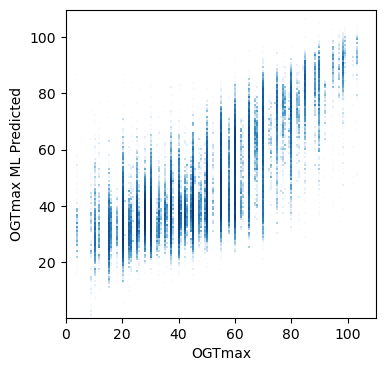

In [61]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

artist = dsshow(df,
       ds.Point('y_test', 'y_pred'),
       # ds.count_cat('type'),       
       cmap='Blues', norm='eq_hist', aspect='equal',
       width_scale=0.5, height_scale=0.5,
       x_range=(0, 110), y_range=(0, 110), ax=ax)

ax.set_xlabel('OGTmax')
ax.set_ylabel('OGTmax ML Predicted')

In [22]:
df.head(2)

,y_test,y_pred
0,10.0,23.795944
1,4.0,34.731430


In [21]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

Text(20.59722222222222, 0.5, 'OGTmax ML Predicted')

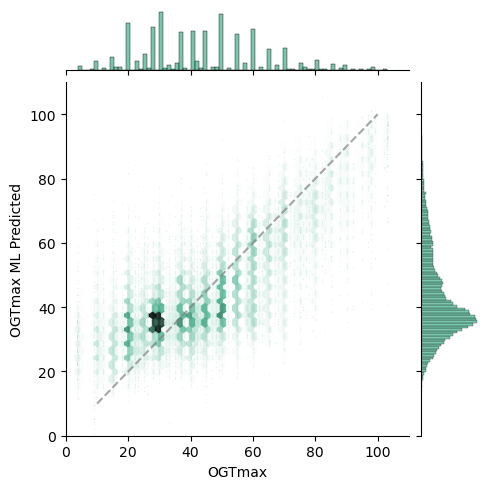

In [23]:
# f, ax = plt.subplots(figsize=(4,4))
g = sns.jointplot(df, x='y_test', y='y_pred', 
                  kind='hex', color="#4CB391", alpha=0.85,
                  xlim=(0,110), ylim=(0,110), height=5)
g.plot_joint(sns.scatterplot, s=1, alpha=1.0, color="#4CB391", zorder=0) #xlim=(0,110), ylim=(0,110))

ax = g.ax_joint
ax.plot([10,100], [10,100], '--', alpha=0.7, color='gray')
ax.set_xlabel('OGTmax')
ax.set_ylabel('OGTmax ML Predicted')

Text(20.59722222222222, 0.5, 'OGTmax ML Predicted')

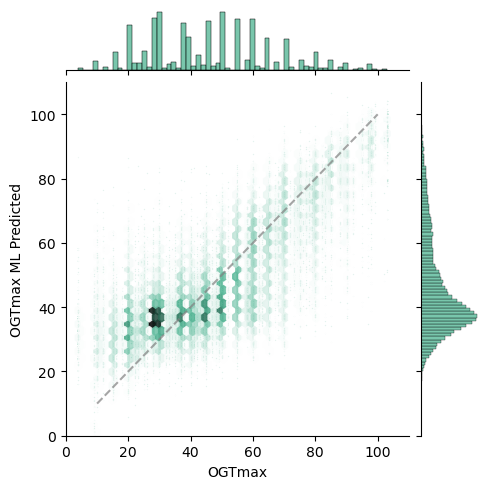

In [89]:
# f, ax = plt.subplots(figsize=(4,4))
g = sns.jointplot(df, x='y_test', y='y_pred', 
                  kind='hex', color="#4CB391", alpha=0.85,
                  xlim=(0,110), ylim=(0,110), height=5)
g.plot_joint(sns.scatterplot, s=1, alpha=1.0, color="#4CB391", zorder=0) #xlim=(0,110), ylim=(0,110))

ax = g.ax_joint
ax.plot([10,100], [10,100], '--', alpha=0.7, color='gray')
ax.set_xlabel('OGTmax')
ax.set_ylabel('OGTmax ML Predicted')

In [104]:
head_model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [106]:
X_test.shape

(54464, 1280)

In [124]:
head_model.linear_relu_stack

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
)

In [122]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

head_model.linear_relu_stack[3].register_forward_hook(get_activation('relu2'))
output = head_model(torch.Tensor(X_test))
activation['relu2']

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 6.6529,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 5.4020,  ..., 0.0000, 0.0000, 0.0000]])

In [50]:
out_file = Path(out_dir, f"20230614_bacdive_uniref50_gt50.pt")
print(out_file)
# trainer.save_checkpoint(out_file)
torch.save(head_model_50, out_file)

/projects/robustmicrob/jlaw/inputs/species/bacdive/embeddings/20230614_bacdive_uniref50_gt50.pt


NameError: name 'head_model_50' is not defined

### Transfer Learning: OGTmax -> Meltome
Now try building another head model on top of this pre-trained model with the meltome dataset to see if it helps

### load the meltome data

In [128]:
inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/")

embeddings, df_seq = read_embeddings(Path(inputs_dir, "meltome/embeddings/20230206_embeddings_esm2_t33_650M_UR50D.npz"),
                                     Path(inputs_dir, "meltome/embeddings/20230206_embeddings_seqs.csv"))


len(embeddings) = 32563 read from /projects/robustmicrob/jlaw/inputs/meltome/embeddings/20230206_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 32563 read from /projects/robustmicrob/jlaw/inputs/meltome/embeddings/20230206_embeddings_seqs.csv


In [129]:
# try using the same train/test splits that flip used
df_split = pd.read_csv(Path(inputs_dir, "meltome/flip/github/splits/mixed_split.csv"))
print(len(df_split))
df_split.head(2)

27951


,sequence,target,set,validation
0,MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNY...,37.962947,train,NaN
1,MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDV...,54.425342,train,NaN


In [130]:
df_split.set.value_counts()

train    24817
test      3134
Name: set, dtype: int64

In [131]:
# df_split = df_split.set_index('sequence')
# df_split_w_embed = df_split.loc[df_seq[df_seq.sequence.isin(df_split.index)].sequence]
df_split_w_embed = df_split[df_split.sequence.isin(df_seq.sequence)]
print(len(df_split_w_embed))

26082


In [132]:
# seq_idx = {seq: idx for idx, seq in df_seq.sequence.items
seq_idx = dict(zip(df_seq.sequence, df_seq.index))
print(list(seq_idx.items())[:2])

[('MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNYKNDTMIRKEATVSESVLSELKRIIEDSEIMQEDDDNWPEPDKIGRQELEILYKNEHISFTTGKIGALADVNNSKDPDGLRSFYYLVQDLKCLVFSLIGLHFKIKPI', 0), ('MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDVMIRKEAYVHKSVMEELKRIIDDSEITKEDDALWPPPDRVGRQELEIVIGDEHISFTTSKIGSLIDVNQSKDPEGLRVFYYLVQDLKCLVFSLIGLHFKIKPI', 1)]


In [133]:
df_train = df_split_w_embed[df_split_w_embed.set == "train"]
print(len(df_train), f"{len(df_train) / len(df_split_w_embed):0.2f}")

# some of the sequences are repeated, so get their embeddings by index
X_train = np.asarray([embeddings[seq_idx[seq]] for seq in df_train.sequence.values])
y_train = df_train.target

df_test = df_split_w_embed[df_split_w_embed.set == "test"]
print(len(df_test), f"{len(df_test) / len(df_split_w_embed):0.2f}")
X_test = np.asarray([embeddings[seq_idx[seq]] for seq in df_test.sequence.values])
y_test = df_test.target

23185 0.89
2897 0.11


In [136]:
class TransferNeuralNetwork(pl.LightningModule):
    def __init__(self, transfer_model, activation):
        super(TransferNeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            # nn.Linear(initial_layer_size, 512),
            # nn.ReLU(),            
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
        self.feature_extractor = transfer_model
        self.feature_extractor.freeze()
        self.activation = activation

    def forward(self, x):
        output = self.feature_extractor(x)
        representations = self.activation['relu2']
        logits = self.linear_relu_stack(representations)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        loss = nn.functional.mse_loss(y_pred, y)        
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [154]:
def fit_model(X_train, y_train, X_valid, y_valid, transfer_model=None, logger=None):
    pl.seed_everything(42)
    if transfer_model:
        # model = TransferNeuralNetwork(transfer_model, activation)
        model = transfer_model
    else:
        model = NeuralNetwork(initial_layer_size=X_train.shape[1])
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=10,
        check_val_every_n_epoch=5,
        logger=logger,
    )
    
    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid).to(device), torch.Tensor(y_valid).to(device))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)

    trainer.fit(model, train_loader)
    
    return model, trainer

In [148]:
head_model.parameters

<bound method Module.parameters of NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)>

In [ ]:
for param in head_model.parameters():
    param.requires_grad = True

In [155]:
meltome_model, trainer = fit_model(X_train, y_train, X_test, y_test, transfer_model=head_model)

Global seed set to 42
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jlaw/.conda/envs/tm/lib/python3.10/site-packag ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | linear_relu_stack | Sequential | 919 K 
------------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [151]:
# y_pred = fit_predict(X_train, y_train, X_test).flatten()
# y_pred = model(torch.Tensor(X_test).to('cuda')[2].unsqueeze(1).detach().cpu()
y_pred = meltome_model(torch.Tensor(X_test)).detach().squeeze().cpu().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = np.abs(y_pred - y_test).mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 4.6, mse = 38.3, rho = 0.64


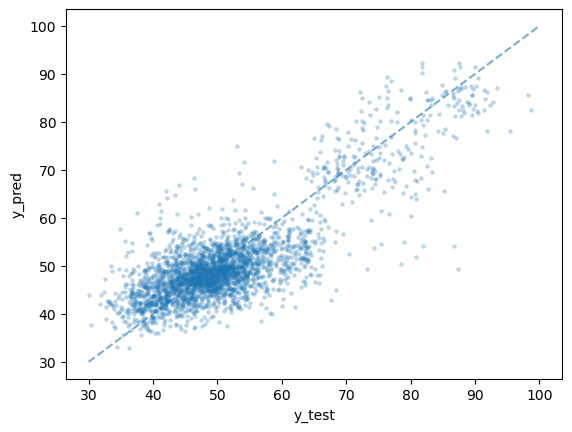

In [152]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([30,100], [30,100], '--', alpha=0.6)
plt.show()

In [ ]:
# 